In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2
from sklearn.metrics import accuracy_score, classification_report
import math

## Training the Multinomial Logistic Regressor, Random Forest Regressor, and Random Forest Classifier with Wellness Data

In [2]:
# Load processed wellness data
df = pd.read_csv("../data/processed/processed_wellness_data.csv")
df.head()

,duration_of_sleep_hours,level_of_physical_activity_minutes_per_day,level_of_stress_scale_110,bmi_category,heart_rate_bpm,systolic_and_diastolic_blood_pressure,nutrition_intake_calories_breakdown_of_nutrients_etc,level_of_workload_scale_110,quality_or_frequency_of_social_interactions,activities_for_mental_health_such_as_therapy_sessions_or_meditation,...,mood_output_encoded,demographic_health_grouping,sleep_health,heart_health,bp_health,lifestyle_grouping,activity_level_grouping,stress_profile_grouping,workload_profile_grouping,social_wellness_grouping
0,7.5,30,5,Normal,72,120/80,2000 calories (balanced diet),6,"Good, frequent",Meditation daily,...,0,HEALTHY_CONSUMPTION,GOOD_SLEEP,GOOD_HEART_RATE,POOR_BLOOD_PRESSURE,NEUTRAL,LIGHTLY_ACTIVE,MEDIUM_STRESS,MEDIUM_WORKLOAD,HIGH_SOCIAL
1,6.8,45,3,Overweight,75,118/78,2500 calories (high in carbs),7,"Moderate, occasional",NaN,...,1,UNHEALTHY_CONSUMPTION,POOR_SLEEP,GOOD_HEART_RATE,GOOD_BLOOD_PRESSURE,NEUTRAL,SOMEWHAT_ACTIVE,LOW_STRESS,MEDIUM_WORKLOAD,MODERATE_SOCIAL
2,8.2,15,8,Underweight,68,115/75,1800 calories (low in protein),9,"Low, infrequent",Therapy sessions weekly,...,2,UNHEALTHY_CONSUMPTION,GOOD_SLEEP,GOOD_HEART_RATE,GOOD_BLOOD_PRESSURE,GOOD,LIGHTLY_ACTIVE,HIGH_STRESS,HIGH_WORKLOAD,MODERATE_SOCIAL
3,7.0,60,4,Normal,70,122/82,2200 calories (healthy diet),5,"Very good, daily",Yoga twice a week,...,0,HEALTHY_CONSUMPTION,GOOD_SLEEP,GOOD_HEART_RATE,POOR_BLOOD_PRESSURE,NEUTRAL,ACTIVE,LOW_STRESS,MEDIUM_WORKLOAD,HIGH_SOCIAL
4,5.5,10,9,Obese,80,130/90,3000 calories (unhealthy),10,"Poor, infrequent",NaN,...,2,UNHEALTHY_CONSUMPTION,POOR_SLEEP,GOOD_HEART_RATE,POOR_BLOOD_PRESSURE,NEUTRAL,SEDENTARY,HIGH_STRESS,HIGH_WORKLOAD,LOW_SOCIAL


#### Cleaning the processed wellness data

In [3]:
# Cleaning nutrition intake
for i in range(len(df['nutrition_intake_calories_breakdown_of_nutrients_etc'])):
    df.loc[i, 'nutrition_intake_calories_breakdown_of_nutrients_etc'] = df['nutrition_intake_calories_breakdown_of_nutrients_etc'][i][:4]

# Encoding BMI category
encoder_bmi = LabelEncoder()
df['bmi_category_encoded'] = encoder_bmi.fit_transform(df['bmi_category'])

# Cleaning env aspects
for i in range(len(df['environmental_aspects_such_as_weather_and_air_quality'])):
    df.loc[i, 'environmental_aspects_such_as_weather_and_air_quality'] = df['environmental_aspects_such_as_weather_and_air_quality'][i].split(',')[0]

# Encoding cleaned env aspects
encoder_env = LabelEncoder()
df['environmental_aspects_such_as_weather_and_air_quality'] = encoder_env.fit_transform(df['environmental_aspects_such_as_weather_and_air_quality'])

# Converting mood output values
for i in np.where(df["mood_output"] == 'Sad'):
    df.loc[i, "mood_output"] = "Negative"
for i in np.where(df["mood_output"] == 'Happy'):
    df.loc[i, "mood_output"] = "Positive" 

# Encoding mood_output
encoder_mood = LabelEncoder()
df["mood_output_encoded"] = encoder_mood.fit_transform(df["mood_output"])

# Creating quality of sleep column
df['quality_of_sleep_110'] = df['duration_of_sleep_hours']
for i in range(len(df['duration_of_sleep_hours'])):
    df.loc[i, 'quality_of_sleep_110'] = math.ceil(df['duration_of_sleep_hours'][i])

# Remove any data point with NaN
# if df.isnull().any().any():
#     df = df.dropna()

# df.head().T

#### Generating the Correlation Matrix

<Axes: >

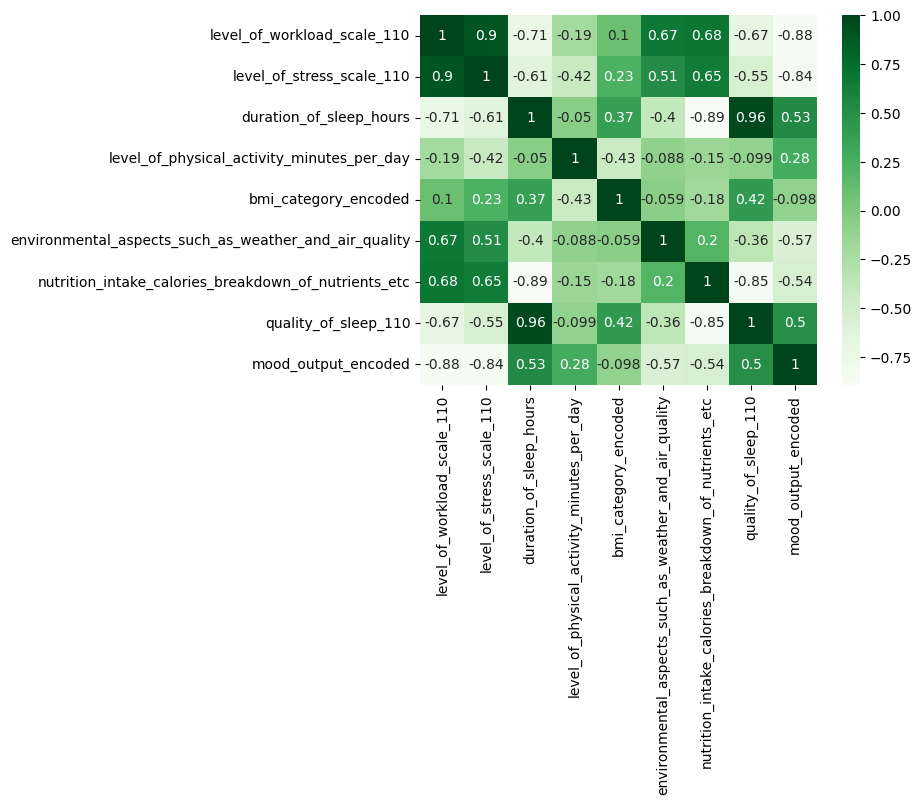

In [4]:
# Selecting columns to general correlation matrix
corr_features = ["level_of_workload_scale_110", "level_of_stress_scale_110", "duration_of_sleep_hours", 
                        "level_of_physical_activity_minutes_per_day", 'bmi_category_encoded', 'environmental_aspects_such_as_weather_and_air_quality'
                , 'nutrition_intake_calories_breakdown_of_nutrients_etc', 'quality_of_sleep_110', 'mood_output_encoded']

corre = df[corr_features].corr()['mood_output_encoded']

testingdf = df[corr_features]
matrix = testingdf.corr()
sns.heatmap(matrix, cmap="Greens", annot=True)

From the correlation matrix, we will be using the ["duration_of_sleep_hours", "quality_of_sleep_110", "level_of_stress_scale_110", "level_of_workload_scale_110"] as a selected features to train the models.

#### Splitting Dataset and Training Multinomial Logistic and Random Forest Regressors

In [5]:
# Spliting the data set into training, validating, and testing data
selected_features = df[["duration_of_sleep_hours", "quality_of_sleep_110", "level_of_stress_scale_110", 
                                "level_of_workload_scale_110"]]
selected_target = df["mood_output_encoded"]

X_training, X_rest, y_training, y_rest = train_test_split(selected_features, selected_target, test_size = 0.3, random_state = 42)
X_validating, X_testing, y_validating, y_testing = train_test_split(X_rest, y_rest, test_size = 0.5, random_state = 42)

print("Total number of data:", df.shape[0])
print("Training set:", X_training.shape[0])
print("Validation set:", X_validating.shape[0])
print("Testing set:", X_testing.shape[0])

Total number of data: 737
Training set: 515
Validation set: 111
Testing set: 111


In [6]:
Mul_Norm_LogReg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 1000)

Mul_Norm_LogReg.fit(X_training, y_training)
print("Training Done")

Training Done


C:\Users\Josue\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [7]:
rand_for = RandomForestRegressor(random_state = 42)

rand_for.fit(X_training, y_training)
print("Training Done")

Training Done


In [8]:
rand_for_classifier = RandomForestClassifier(random_state = 42)

rand_for_classifier.fit(X_training, y_training)
print("Training Done")

Training Done


#### Visualizing Validation with Validating Data

In [9]:
# Validation
Mul_Norm_vali_pred = Mul_Norm_LogReg.predict(X_validating)
rand_for_vali_pred = rand_for.predict(X_validating)
rand_for_class_vali_pred = rand_for_classifier.predict(X_validating)

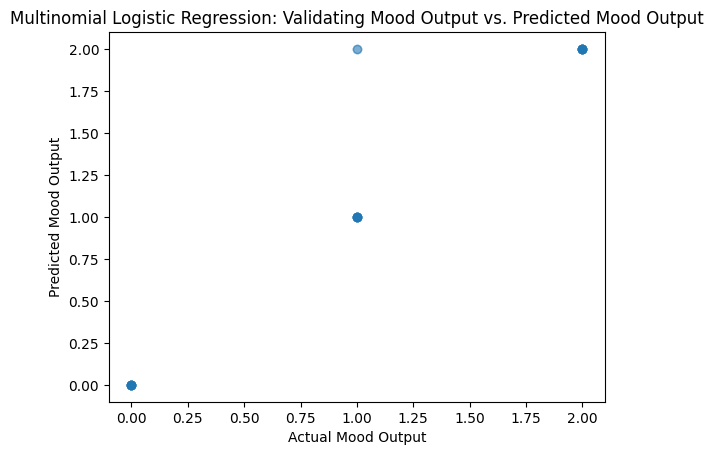

In [10]:
plt.scatter(y_validating, y = Mul_Norm_vali_pred, alpha = 0.1)
plt.title("Multinomial Logistic Regression: Validating Mood Output vs. Predicted Mood Output")
plt.xlabel("Actual Mood Output")
plt.ylabel("Predicted Mood Output")
plt.show()

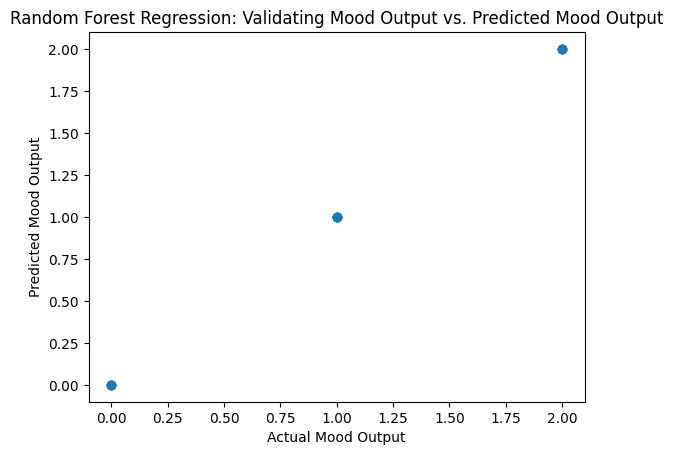

In [11]:
plt.scatter(y_validating, y = rand_for_vali_pred, alpha = 0.1)
plt.title("Random Forest Regression: Validating Mood Output vs. Predicted Mood Output")
plt.xlabel("Actual Mood Output")
plt.ylabel("Predicted Mood Output")
plt.show()

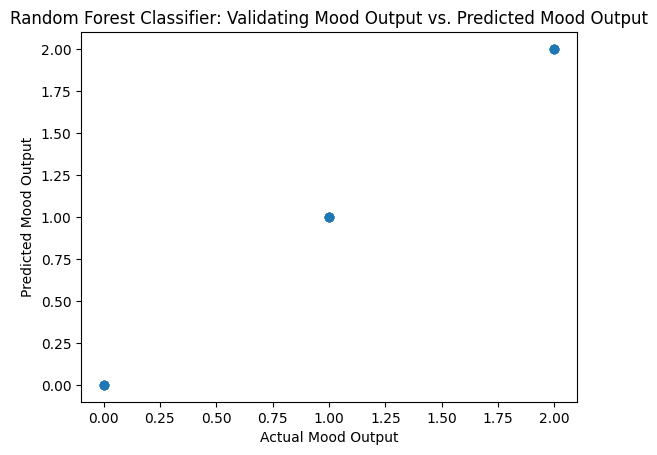

In [12]:
plt.scatter(y_validating, y = rand_for_class_vali_pred, alpha = 0.1)
plt.title("Random Forest Classifier: Validating Mood Output vs. Predicted Mood Output")
plt.xlabel("Actual Mood Output")
plt.ylabel("Predicted Mood Output")
plt.show()

#### Evaluating Regressors and Classifier with Testing Data

In [13]:
Mul_Norm_test_pred = Mul_Norm_LogReg.predict(X_testing)
rand_for_test_pred = rand_for.predict(X_testing)
rand_for_class_test_pred = rand_for_classifier.predict(X_testing)

Mul_Norm_MAE = MAE(y_testing, Mul_Norm_test_pred)
Mul_Norm_MSE = MSE(y_testing, Mul_Norm_test_pred)
Mul_Norm_R2 = R2(y_testing, Mul_Norm_test_pred)

rand_for_MAE = MAE(y_testing, rand_for_test_pred)
rand_for_MSE = MSE(y_testing, rand_for_test_pred)
rand_for_R2 = R2(y_testing, rand_for_test_pred)

rand_for_class_report = classification_report(y_testing, rand_for_class_test_pred)

print("Multinomial Logistic Regression:")
print("Mean Absolute Error:", Mul_Norm_MAE)
print("Mean Square Error:", Mul_Norm_MSE)
print("R-2 Score:", Mul_Norm_R2)
print("Prediction Accuracy:", accuracy_score(y_testing, Mul_Norm_test_pred))
print()
print("Random Forest Regression:")
print("Mean Absolute Error:", rand_for_MAE)
print("Mean Square Error:", rand_for_MSE)
print("R-2 Score:", rand_for_R2)
print()
print("Random Forest Classification Report:")
print(rand_for_class_report)
print("Classifier Probability for each Class:")
print(rand_for_classifier.predict_proba(X_testing))

Multinomial Logistic Regression:
Mean Absolute Error: 0.0990990990990991
Mean Square Error: 0.0990990990990991
R-2 Score: 0.8619715125480443
Prediction Accuracy: 0.9009009009009009

Random Forest Regression:
Mean Absolute Error: 0.0
Mean Square Error: 0.0
R-2 Score: 1.0

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        49
           1       1.00      1.00      1.00        29
           2       1.00      1.00      1.00        33

    accuracy                           1.00       111
   macro avg       1.00      1.00      1.00       111
weighted avg       1.00      1.00      1.00       111

Classifier Probability for each Class:
[[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0.

Analyzing the error and R2 score values, we see that all the multinomial logistic regressor, random forest regressor, and random forest classifier are performing well on predicting the testing wellness data. However, while the multinomial logistic regressor predicted the mood output with 94% accuracy with 0.93 R2 score, which performed well and would not need to worry for overfitting, the random forest regressor and classifier predicted the mood output perfectly. This could raise some concern of overfitting for the random forest regressor and classifier for the size of the training data was too small (310); due to the characteristic of the random forest models such as boosting, the random forest regressor and classifier could fit too well with the data trend and complexity in the small size of training data. Thus, we will perform the data augmentation on the wellness_data to increase the size of the data to 1400 rows and train the same models again.

## Training the Multinomial Logistic Regressor, Random Forest Regressor, and Random Forest Classifier with Augmented Wellness Data

In [14]:
# Load augmented wellness data
df_aug = pd.read_csv("../data/processed/Augmented_Wellness_Dataset.csv")
df_aug.head()

,level_of_workload_scale_110,level_of_stress_scale_110,duration_of_sleep_hours,level_of_physical_activity_minutes_per_day,environmental_aspects_such_as_weather_and_air_quality,nutrition_intake_calories_breakdown_of_nutrients_etc,mood_output
0,6.0,5.0,7.5,30.0,"Sunny, good air quality",2000 calories (balanced diet),Happy
1,7.0,3.0,6.8,45.0,"Rainy, poor air quality",2500 calories (high in carbs),Neutral
2,9.0,8.0,8.2,15.0,"Sunny, good air quality",1800 calories (low in protein),Sad
3,5.0,4.0,7.0,60.0,"Cloudy, moderate air quality",2200 calories (healthy diet),Happy
4,10.0,9.0,5.5,10.0,"Sunny, good air quality",3000 calories (unhealthy),Sad


In [15]:
# Check rows of the augmented data
df_aug.shape[0]

1400

#### Cleaning the augmented wellness data

In [16]:
# Cleaning nutrition intake
for i in range(len(df_aug['nutrition_intake_calories_breakdown_of_nutrients_etc'])):
    df_aug.loc[i, 'nutrition_intake_calories_breakdown_of_nutrients_etc'] = df_aug['nutrition_intake_calories_breakdown_of_nutrients_etc'][i][:4]

# Cleaning env aspects
for i in range(len(df_aug['environmental_aspects_such_as_weather_and_air_quality'])):
    df_aug.loc[i, 'environmental_aspects_such_as_weather_and_air_quality'] = df_aug['environmental_aspects_such_as_weather_and_air_quality'][i].split(',')[0]

# Encoding cleaned env aspects
df_aug['environmental_aspects_such_as_weather_and_air_quality'] = encoder_env.transform(df_aug['environmental_aspects_such_as_weather_and_air_quality'])

# Converting mood output values
for i in np.where(df_aug["mood_output"] == 'Sad'):
    df_aug.loc[i, "mood_output"] = "Negative"
for i in np.where(df_aug["mood_output"] == 'Happy'):
    df_aug.loc[i, "mood_output"] = "Positive" 

# Encoding mood_output
df_aug["mood_output_encoded"] = encoder_mood.transform(df_aug["mood_output"])

# Creating quality of sleep column
df_aug['quality_of_sleep_110'] = df_aug['duration_of_sleep_hours']
for i in range(len(df_aug['duration_of_sleep_hours'])):
    df_aug.loc[i, 'quality_of_sleep_110'] = math.ceil(df_aug['duration_of_sleep_hours'][i])

# Remove any data point with NaN
if df_aug.isnull().any().any():
    df_aug = df_aug.dropna()

df_aug.head()

,level_of_workload_scale_110,level_of_stress_scale_110,duration_of_sleep_hours,level_of_physical_activity_minutes_per_day,environmental_aspects_such_as_weather_and_air_quality,nutrition_intake_calories_breakdown_of_nutrients_etc,mood_output,mood_output_encoded,quality_of_sleep_110
0,6.0,5.0,7.5,30.0,2,2000,Positive,2,8.0
1,7.0,3.0,6.8,45.0,1,2500,Neutral,1,7.0
2,9.0,8.0,8.2,15.0,2,1800,Negative,0,9.0
3,5.0,4.0,7.0,60.0,0,2200,Positive,2,7.0
4,10.0,9.0,5.5,10.0,2,3000,Negative,0,6.0


#### Generating the Correlation Matrix

<Axes: >

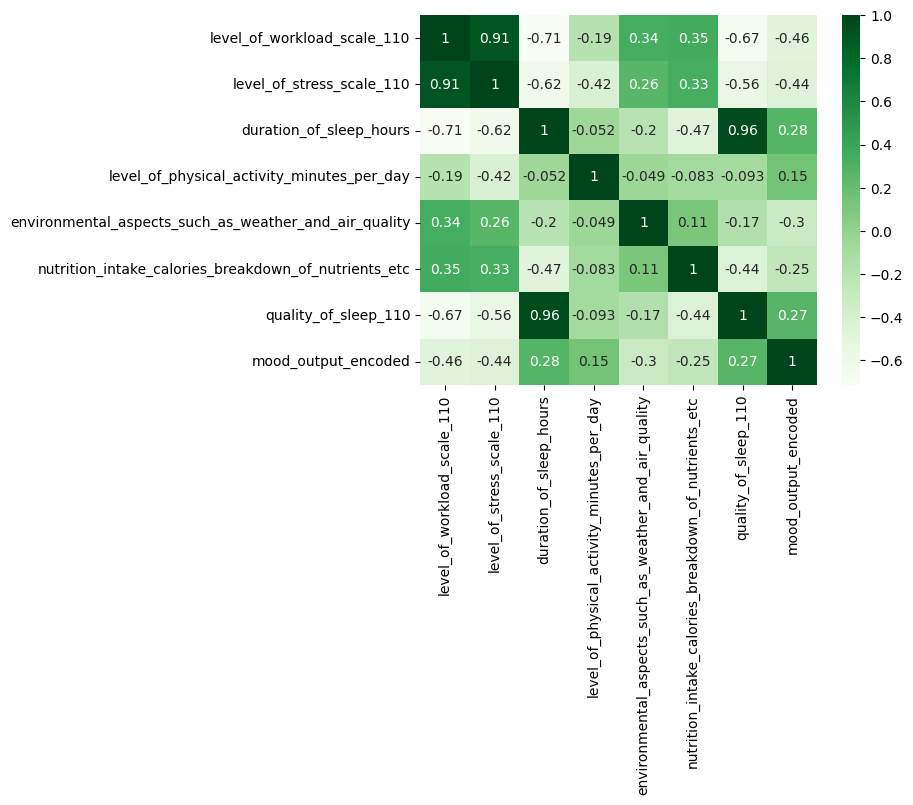

In [17]:
corr_features = ["level_of_workload_scale_110", "level_of_stress_scale_110", "duration_of_sleep_hours", 
                        "level_of_physical_activity_minutes_per_day", 'environmental_aspects_such_as_weather_and_air_quality'
                , 'nutrition_intake_calories_breakdown_of_nutrients_etc', 'quality_of_sleep_110', 'mood_output_encoded']

corre = df_aug[corr_features].corr()['mood_output_encoded']

testingdf = df_aug[corr_features]
matrix = testingdf.corr()
sns.heatmap(matrix, cmap="Greens", annot=True)

#### Splitting Dataset and Training Multinomial Logistic and Random Forest Regressors

In [18]:
selected_features_aug = df_aug[["duration_of_sleep_hours", "quality_of_sleep_110", "level_of_stress_scale_110", 
                                "level_of_workload_scale_110"]]
target_aug = df_aug["mood_output_encoded"]

X_train, X_rest_aug, y_train, y_rest_aug = train_test_split(selected_features_aug, target_aug, test_size = 0.2, random_state = 42)
X_validate, X_test, y_validate, y_test = train_test_split(X_rest_aug, y_rest_aug, test_size = 0.5, random_state = 42)

print("Total number of data:", df_aug.shape[0])
print("Training set:", X_train.shape[0])
print("Validation set:", X_validate.shape[0])
print("Testing set:", X_test.shape[0])

Total number of data: 1400
Training set: 1120
Validation set: 140
Testing set: 140


In [19]:
MultiLog_Reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 1000)
RF_Reg = RandomForestRegressor(random_state = 42)
RF_Class = RandomForestClassifier(random_state = 42)

MultiLog_Reg.fit(X_train, y_train)
RF_Reg.fit(X_train, y_train)
RF_Class.fit(X_train, y_train)
print("Training Done")

C:\Users\Josue\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training Done


#### Evaluating Regressors and Classifier with Testing Data

In [20]:
ML_test_pred = MultiLog_Reg.predict(X_test)
RF_Reg_test_pred = RF_Reg.predict(X_test)
RF_class_test_pred = RF_Class.predict(X_test)

ML_MAE = MAE(y_test, ML_test_pred)
ML_MSE = MSE(y_test, ML_test_pred)
ML_R2 = R2(y_test, ML_test_pred)

RF_MAE = MAE(y_test, RF_Reg_test_pred)
RF_MSE = MSE(y_test, RF_Reg_test_pred)
RF_R2 = R2(y_test, RF_Reg_test_pred)

RF_class_report = classification_report(y_test, RF_class_test_pred)

print("Multinomial Logistic Regression:")
print("Mean Absolute Error:", ML_MAE)
print("Mean Square Error:", ML_MSE)
print("R-2 Score:", ML_R2)
print("Prediction Accuracy:", accuracy_score(y_test, ML_test_pred))
print()
print("Random Forest Regression:")
print("Mean Absolute Error:", RF_MAE)
print("Mean Square Error:", RF_MSE)
print("R-2 Score:", RF_R2)
print()
print("Random Forest Classification report:")
print(RF_class_report)
print("Classifier Probability for each Class:")
print(RF_Class.predict_proba(X_test))

Multinomial Logistic Regression:
Mean Absolute Error: 0.4142857142857143
Mean Square Error: 0.5714285714285714
R-2 Score: 0.17373662855035032
Prediction Accuracy: 0.6642857142857143

Random Forest Regression:
Mean Absolute Error: 0.3791683238908829
Mean Square Error: 0.3655982586966993
R-2 Score: 0.47135921280300197

Random Forest Classification report:
              precision    recall  f1-score   support

           0       0.70      0.69      0.69        51
           1       0.62      0.67      0.64        43
           2       0.77      0.72      0.74        46

    accuracy                           0.69       140
   macro avg       0.69      0.69      0.69       140
weighted avg       0.70      0.69      0.69       140

Classifier Probability for each Class:
[[6.73119048e-01 1.82619048e-02 3.08619048e-01]
 [0.00000000e+00 3.23041180e-02 9.67695882e-01]
 [8.92145722e-02 0.00000000e+00 9.10785428e-01]
 [9.70385605e-01 2.96143951e-02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 

## Testing the Trained Models with Tracker Log Dataset

To test if the trained regressors and classifier would perform prediction well with the actual user data, we recorded our own data and will test the prediction with the trained models.

In [21]:
testDf = pd.read_csv("../data/raw/CS-GY-6923 Log Tracker  - Daily Questions.csv")

testDf.head()

,Date,Duration of Sleep (hours),Quality of Sleep (1-10),Daily Weigh-in,BMI Category,"Nutrition Intake (calories, breakdown of nutrients, etc.)",Level of Physical Activity (minutes per day),Heart Rate (bpm),Systolic and Diastolic Blood Pressure,Level of Stress (scale: 1–10),Level of Workload (scale: 1–10),Environmental Aspects (such as weather and air quality),"Additional health indicators (e.g., water levels, steps)",Mood Output,Notes
0,03/14/2025,4,5,126.5,Normal,1750 Calories (Balanced),60,71,117/55,6,5,"Sunny, Good Air Quality","1.5 Liter, 1000 Steps",Negative,"Barely had any sleep, feeling terrible"
1,03/15/2025,5,5,126.0,Normal,1700 Calories (Balanced),20,69,114/53,5,4,"Cloudy, Good Air Quality","1.25 Liter, 2105 Steps",Neutral,Regular day
2,03/16/2025,6,6,125.6,Normal,1800 Calories (High in Protein),75,68,111/51,3,4,"Cloudy, Good Air Quality","1 Liter, 8851 Steps",Positive,"Went out for a long jog, I enjoyed it"
3,03/17/2025,6,6,126.2,Normal,"1900 Calories (High in Carbs, Balanced)",80,70,102/55,2,4,"Cloudy, Good Air Quality","0.75 Liter, 2251 Steps",Positive,"Went out for a short jog and lifted weights, i..."
4,03/18/2025,7,7,126.8,Normal,"1760 Calories (Low in Protein, Healthy)",90,67,118/53,3,3,"Sunny, Good Air Quality","0.85 Liter, 11080 Steps",Positive,"Went out for a long jog, good weather, it was ..."


#### Cleaning the Tracker Log Data

In [22]:
# Rename columns as the ones in the wellness data
testDf = testDf.rename(columns={'Quality of Sleep  (1-10)': 'quality_of_sleep_110',
                          'Level of Stress (scale: 1–10)': "level_of_stress_scale_110",
                          'Level of Workload (scale: 1–10)': "level_of_workload_scale_110",
                          'Duration of Sleep (hours)': "duration_of_sleep_hours",
                            'Level of Physical Activity (minutes per day)': "level_of_physical_activity_minutes_per_day",
                            'Nutrition Intake (calories, breakdown of nutrients, etc.)': 'nutrition_intake_calories_breakdown_of_nutrients_etc',
                            'Environmental Aspects (such as weather and air quality)': 'environmental_aspects_such_as_weather_and_air_quality',
                             'Mood Output': "mood_output"})

# To follow some data trend in the wellness data, keep the range of the lebel of physical activity  from 0 to 60
for i in np.where(testDf["level_of_physical_activity_minutes_per_day"] > 60)[0]:
    testDf.loc[i, "level_of_physical_activity_minutes_per_day"] = 60

# Cleaning nutrition intake
for i in range(len(testDf['nutrition_intake_calories_breakdown_of_nutrients_etc'])):
    testDf.loc[i, 'nutrition_intake_calories_breakdown_of_nutrients_etc'] = testDf['nutrition_intake_calories_breakdown_of_nutrients_etc'][i][:4]

# Cleaning env aspects
for i in range(len(testDf['environmental_aspects_such_as_weather_and_air_quality'])):
    testDf.loc[i, 'environmental_aspects_such_as_weather_and_air_quality'] = testDf['environmental_aspects_such_as_weather_and_air_quality'][i].split(',')[0]

# Encoding cleaned env aspects
testDf['environmental_aspects_such_as_weather_and_air_quality'] = encoder_env.transform(testDf['environmental_aspects_such_as_weather_and_air_quality'])

# Converting mood output values
for i in np.where(testDf["mood_output"] == 'Sad'):
    testDf.loc[i, "mood_output"] = "Negative"
for i in np.where(testDf["mood_output"] == 'Happy'):
    testDf.loc[i, "mood_output"] = "Positive" 

# Encoding mood_output
testDf["mood_output_encoded"] = encoder_mood.transform(testDf["mood_output"])

# Remove any data point with NaN
if testDf.isnull().any().any():
    testDf = testDf.dropna()

testDf.head()

,Date,duration_of_sleep_hours,quality_of_sleep_110,Daily Weigh-in,BMI Category,nutrition_intake_calories_breakdown_of_nutrients_etc,level_of_physical_activity_minutes_per_day,Heart Rate (bpm),Systolic and Diastolic Blood Pressure,level_of_stress_scale_110,level_of_workload_scale_110,environmental_aspects_such_as_weather_and_air_quality,"Additional health indicators (e.g., water levels, steps)",mood_output,Notes,mood_output_encoded
0,03/14/2025,4,5,126.5,Normal,1750,60,71,117/55,6,5,2,"1.5 Liter, 1000 Steps",Negative,"Barely had any sleep, feeling terrible",0
1,03/15/2025,5,5,126.0,Normal,1700,20,69,114/53,5,4,0,"1.25 Liter, 2105 Steps",Neutral,Regular day,1
2,03/16/2025,6,6,125.6,Normal,1800,60,68,111/51,3,4,0,"1 Liter, 8851 Steps",Positive,"Went out for a long jog, I enjoyed it",2
3,03/17/2025,6,6,126.2,Normal,1900,60,70,102/55,2,4,0,"0.75 Liter, 2251 Steps",Positive,"Went out for a short jog and lifted weights, i...",2
4,03/18/2025,7,7,126.8,Normal,1760,60,67,118/53,3,3,2,"0.85 Liter, 11080 Steps",Positive,"Went out for a long jog, good weather, it was ...",2


#### Generating the Correlation Matrix

<Axes: >

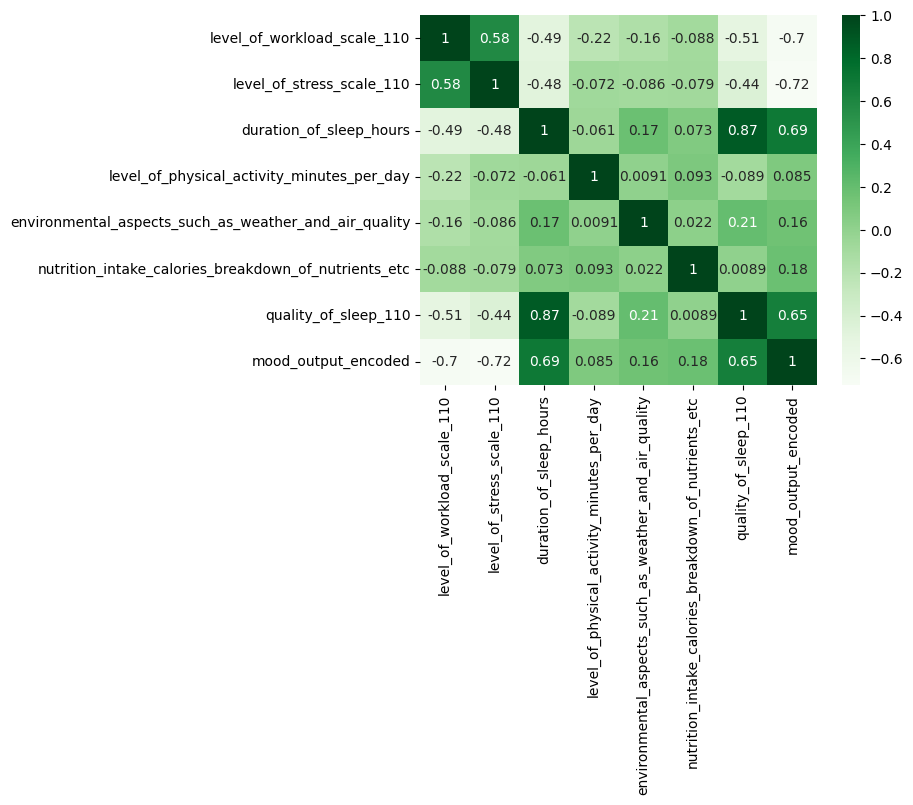

In [23]:
corr_features = ["level_of_workload_scale_110", "level_of_stress_scale_110", "duration_of_sleep_hours", 
                        "level_of_physical_activity_minutes_per_day", 'environmental_aspects_such_as_weather_and_air_quality'
                , 'nutrition_intake_calories_breakdown_of_nutrients_etc', 'quality_of_sleep_110', 'mood_output_encoded']

corre = testDf[corr_features].corr()['mood_output_encoded']

testingdf = testDf[corr_features]
matrix = testingdf.corr()
sns.heatmap(matrix, cmap="Greens", annot=True)

#### Evaluating Prediction of Regressors and Classifier Trained with Augmented Wellness Data on Tracker Log Data

In [24]:
features_test = ["duration_of_sleep_hours", "quality_of_sleep_110", "level_of_stress_scale_110", "level_of_workload_scale_110"]
target_test = ["mood_output_encoded"]

features_logTest = testDf[features_test]
target_logTest = testDf[target_test]

ML_tracker_pred = MultiLog_Reg.predict(features_logTest)
RF_tracker_pred = RF_Reg.predict(features_logTest)
RF_tracker_class_pred = RF_Class.predict(features_logTest)

ML_tracker_MAE = MAE(target_logTest, ML_tracker_pred)
ML_tracker_MSE = MSE(target_logTest, ML_tracker_pred)
ML_tracker_R2 = R2(target_logTest, ML_tracker_pred)

RF_tracker_MAE = MAE(target_logTest, RF_tracker_pred)
RF_tracker_MSE = MSE(target_logTest, RF_tracker_pred)
RF_tracker_R2 = R2(target_logTest, RF_tracker_pred)

RF_tracker_report = classification_report(target_logTest, RF_tracker_class_pred)

print("Multinomial Logistic Regression:")
print("Mean Absolute Error:", ML_tracker_MAE)
print("Mean Square Error:", ML_tracker_MSE)
print("R-2 Score:", ML_tracker_R2)
print("Accuracy:", accuracy_score(target_logTest, ML_tracker_pred))
print()
print("Random Forest Regression:")
print("Mean Absolute Error:", RF_tracker_MAE)
print("Mean Square Error:", RF_tracker_MSE)
print("R-2 Score:", RF_tracker_R2)
print()
print("Random Forest Classifier Report:")
print(RF_tracker_report)
print("Classifier Probability for each Class:")
print(RF_Class.predict_proba(features_logTest))

Multinomial Logistic Regression:
Mean Absolute Error: 0.5294117647058824
Mean Square Error: 0.7058823529411765
R-2 Score: -0.2592592592592593
Accuracy: 0.5588235294117647

Random Forest Regression:
Mean Absolute Error: 0.8109389600812483
Mean Square Error: 0.9491829786117224
R-2 Score: -0.693295560609801

Random Forest Classifier Report:
              precision    recall  f1-score   support

           0       0.05      0.17      0.08         6
           1       0.00      0.00      0.00        12
           2       0.30      0.19      0.23        16

    accuracy                           0.12        34
   macro avg       0.12      0.12      0.10        34
weighted avg       0.15      0.12      0.12        34

Classifier Probability for each Class:
[[0.42127388 0.30846454 0.27026159]
 [0.3765     0.2165     0.407     ]
 [0.53016667 0.15885714 0.31097619]
 [0.25233446 0.09       0.65766554]
 [0.80119048 0.13571429 0.06309524]
 [0.4265     0.179      0.3945    ]
 [0.5665     0.05373684 

#### Evaluating Prediction of Regressors and Classifier Trained with Processed Wellness Data on Tracker Log Data

In [25]:
ML_tracker_pred2 = Mul_Norm_LogReg.predict(features_logTest)
RF_tracker_pred2 = rand_for.predict(features_logTest)
rand_for_class_test_pred2 = rand_for_classifier.predict(features_logTest)

ML_tracker_MAE2 = MAE(target_logTest, ML_tracker_pred2)
ML_tracker_MSE2 = MSE(target_logTest, ML_tracker_pred2)
ML_tracker_R2_2 = R2(target_logTest, ML_tracker_pred2)

RF_tracker_MAE2 = MAE(target_logTest, RF_tracker_pred2)
RF_tracker_MSE2 = MSE(target_logTest, RF_tracker_pred2)
RF_tracker_R2_2 = R2(target_logTest, RF_tracker_pred2)

RF_tracker_report2 = classification_report(target_logTest, rand_for_class_test_pred2)

print("Multinomial Logistic Regression:")
print("Mean Absolute Error:", ML_tracker_MAE2)
print("Mean Square Error:", ML_tracker_MSE2)
print("R-2 Score:", ML_tracker_R2_2)
print("Accuracy:", accuracy_score(target_logTest, ML_tracker_pred2))
print()
print()
print("Random Forest Regression:")
print("Mean Absolute Error:", RF_tracker_MAE2)
print("Mean Square Error:", RF_tracker_MSE2)
print("R-2 Score:", RF_tracker_R2_2)
print()
print("Random Forest Classifier Report:")
print(RF_tracker_report2)
print("Classifier Probability for each Class:")
print(rand_for_classifier.predict_proba(features_logTest))

Multinomial Logistic Regression:
Mean Absolute Error: 0.6764705882352942
Mean Square Error: 0.9705882352941176
R-2 Score: -0.7314814814814814
Accuracy: 0.47058823529411764


Random Forest Regression:
Mean Absolute Error: 0.4855882352941176
Mean Square Error: 0.3269676470588236
R-2 Score: 0.41670586419753075

Random Forest Classifier Report:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.48      1.00      0.65        12
           2       1.00      0.31      0.48        16

    accuracy                           0.62        34
   macro avg       0.83      0.66      0.64        34
weighted avg       0.82      0.62      0.59        34

Classifier Probability for each Class:
[[0.21 0.46 0.33]
 [0.21 0.41 0.38]
 [0.21 0.4  0.39]
 [0.21 0.4  0.39]
 [0.   0.01 0.99]
 [0.21 0.41 0.38]
 [0.21 0.41 0.38]
 [0.21 0.41 0.38]
 [0.6  0.25 0.15]
 [0.6  0.4  0.  ]
 [0.21 0.41 0.38]
 [0.21 0.4  0.39]
 [0.21 0.41 0.38]
 [0

When we compared the prediction performances of the models trained with the processed wellness data and the augmented wellness data, the random forest models trained with the processed wellness data performed better in the mood output prediction than the random forest models with the augmented wellness data. This could be for struggling to integrate the data trend and complexity of the processed wellness data into the augmented wellness data and the random forest models fit well with processed wellness data. This is seen by comparing the correlation matrix and the prediction performance for the processed and augmented wellness data, where the correlations between the selected features and the mood output is much greater in the processed wellenss data than the augmented wellness data, and the overall predictions of the models trained with the processed wellness data are more accurate than the ones trained with the augmented wellness data.

While we concerned for the overfitting for the random forest models trained with the processed wellness data, we observed from the evaluation with the tracker log data that the random forest classifier and multinomial logistic regressor performed not bad in predicting the mood output from the tracker log data with about 60% for both models. However, we see that the random forest regressor performs bad in mood prediction, which tells us that the model fit too much to the data trend and complexity of the processed wellness data so that it could not perform well with the tracker log data, which has different data trend and complexity.

Since we are going to integrate the mood regressor or classifier with the LLM model that also predicts the mood output from the user notes to produce the final mood prediction, we need to produce a tensor output for each row with the probability for each class (negative, neutral, positive). Thus, instead of using the regression model, which calulates different weights for each features depending on their correlation to the target and derive a single output (the predicted value for mood), we are going to use the random forest classifier trained with the processed wellness data for its decent prediction performance compared to the one trained with the augmented wellness data and for its characteristic of calculating the possible probability for each class and deriving the final output (predicted value for mood) by comparing the liklihood of each class.

## Cleaned Random Forest Classifier and Tensor Invoker

In [26]:
# Import tracker log data
# trackerLogDF = pd.read_csv("../data/raw/CS-GY-6923 Log Tracker  - Daily Questions.csv")
trackerLogDF = pd.read_csv("../data/processed/processed_log_tracker.csv")

# Rename column names
# def rename_columns(df, duration_of_sleep_column, quality_of_sleep_column, level_of_stress_column, level_of_workload_column, emotion_classification_column):
#     df = df.rename(columns={duration_of_sleep_column: "duration_of_sleep_hours",
#                             quality_of_sleep_column: 'quality_of_sleep_110',
#                             level_of_stress_column: "level_of_stress_scale_110",
#                             level_of_workload_column: "level_of_workload_scale_110",
#                             emotion_classification_column: "mood_output"})
#     return df
    
# trackerLogDF = rename_columns(trackerLogDF, 'Duration of Sleep (hours)', 'Quality of Sleep  (1-10)', 'Level of Stress (scale: 1–10)', 'Level of Workload (scale: 1–10)', 'Mood Output')

# # Clean tracker log data
# if trackerLogDF.isnull().any().any():
#     trackerLogDF = trackerLogDF.dropna()

# for i in np.where(trackerLogDF['Level of Physical Activity (minutes per day)'] > 60)[0]:
#     trackerLogDF.loc[i, 'Level of Physical Activity (minutes per day)'] = 60

# # Converting mood output values
# for i in np.where(trackerLogDF["mood_output"] == 'Sad'):
#     trackerLogDF.loc[i, "mood_output"] = "Negative"
# for i in np.where(trackerLogDF["mood_output"] == 'Happy'):
#     trackerLogDF.loc[i, "mood_output"] = "Positive" 

# Encoding mood_output
trackerLogDF['mood_output_encoded'] = trackerLogDF['mood_output']

for i in np.where(trackerLogDF["mood_output_encoded"] == 'Negative'):
    trackerLogDF.loc[i, "mood_output_encoded"] = 0
for i in np.where(trackerLogDF["mood_output_encoded"] == 'Neutral'):
    trackerLogDF.loc[i, "mood_output_encoded"] = 1 
for i in np.where(trackerLogDF["mood_output_encoded"] == 'Positive'):
    trackerLogDF.loc[i, "mood_output_encoded"] = 2

# Predict mood status with pre-trained random forest classifier and return probability of class tensor
def Invoke_Regressor(df, features_selected):
    # The random forest classifier trained with augmented wellness data
    regressor_output_prob = rand_for_classifier.predict_proba(df[features_selected])
    return regressor_output_prob

# Feature selection and target setting
features_selected = ["duration_of_sleep_hours", "quality_of_sleep_110", "level_of_stress_scale_110", "level_of_workload_scale_110"]
target = ["mood_output_encoded"]

print(Invoke_Regressor(trackerLogDF, features_selected))

[[0.21 0.46 0.33]
 [0.21 0.41 0.38]
 [0.21 0.4  0.39]
 [0.21 0.4  0.39]
 [0.   0.01 0.99]
 [0.21 0.41 0.38]
 [0.21 0.41 0.38]
 [0.21 0.41 0.38]
 [0.6  0.25 0.15]
 [0.6  0.4  0.  ]
 [0.21 0.41 0.38]
 [0.21 0.4  0.39]
 [0.21 0.41 0.38]
 [0.21 0.4  0.39]
 [0.   0.01 0.99]
 [0.6  0.25 0.15]
 [0.21 0.79 0.  ]
 [0.21 0.41 0.38]
 [0.   0.52 0.48]
 [0.21 0.46 0.33]
 [0.21 0.41 0.38]
 [0.   0.01 0.99]
 [0.21 0.46 0.33]
 [0.6  0.4  0.  ]
 [0.21 0.41 0.38]
 [0.21 0.41 0.38]
 [0.   0.01 0.99]
 [0.21 0.79 0.  ]
 [0.21 0.46 0.33]
 [0.21 0.41 0.38]
 [0.21 0.4  0.39]
 [0.21 0.41 0.38]
 [0.21 0.46 0.33]
 [0.   0.01 0.99]]
